# INEGIpy

INEGIpy es una librería para interactuar fácilmente con los datos del Instituto Nacional de Geografía y Estadística (INEGI) desde Python. Su propósito es apoyar en la creación de consultas automatizadas y  en el acceso a la información para el análisis de datos. 

De la información que ofrece el INEGI actualmente se cuenta con una clase dedicada al [Banco de Indicadores](https://www.inegi.org.mx/servicios/api_indicadores.html), otra dedicada al [DENUE](https://www.inegi.org.mx/servicios/api_denue.html), otra a la información del [Marco Geoestadístico](https://www.inegi.org.mx/servicios/catalogoUnico.html) y finalmente una dedicada al [Sistema de Ruteo de México](https://www.inegi.org.mx/servicios/Ruteo/Default.html). 

También se encuentra en constrcción un módulo de Series dedicado a consultas automatizadas de los principales indicadores económicos como el PIB, INPC, Ocupación, etc. 

## Principales características

* Permite un acceso rápido a las bases de datos del INEGI sin necesidad de descargas.
* Regresa la información en DataFrames o GeoDataFrames listos para su uso en Python.
* Para el caso de los indicadores económicos, el DataFrame resultante cuenta con un DateTimeIndex y una columna para cada indicador.
* Para las bases con información georeferenciada (DENUE, Marco Geoestadístico y Ruteo) se regresa un GeoDataFrame listo para realizar operaciones espaciales. 
    * El DENUE obtiene tanto la ubicción de los establecimientos como información sobre la actividad económica y el número de trabajadores.
    * El Marco Geoestadístico permite obtener la información de la población según el [Censo de Población y Vivienda del 2020](https://www.inegi.org.mx/programas/ccpv/2020/) así como la información vectorial de las áreas que se especifiquen en cualquier nivel de agregación espacial. Evita descargar un montón de archivos Shape para realizar mapas y operaciones espaciales.
    * El Servicio de Ruteo además de calcular rutas entre puntos ofrece información georeferenciada sobre diferentes destinos los cuales pueden ser destinos turísticos o lugares de interés como aeropuertos, puertos, servicios médicos, o centros educativos de nivel superior. También ofrece detalles sobre el costo de las rutas y los precios promedio de los combustibles. 

## Requerimientos

* pandas
* numpy
* requests
* shapely
* geopandas

La instalación de GeoPandas puede ser un poco complicada de manejar por lo que se recomieda [instalarla previemente](https://geopandas.org/en/stable/getting_started/install.html).


## Instalación

```pip install INEGIpy```

## Cambios recientes

### Versión 2.0.0 — Actualización por cambios en la API de INEGI

Esta versión adapta la librería a las modificaciones recientes realizadas por INEGI en su API, con el objetivo de mantener la compatibilidad y el funcionamiento correcto de las consultas.

#### Cambios principales

* Se actualizó la integración para alinearse con la nueva estructura y comportamiento de la API de INEGI.
* El parámetro banco ya no es necesario para realizar consultas.

#### Compatibilidad hacia atrás

* El parámetro banco se mantiene en las funciones únicamente por compatibilidad con versiones anteriores.
* Actualmente no tiene ningún efecto en el comportamiento de la librería.
* Se recomienda dejar de usar el parámetro banco, ya que podría eliminarse en versiones posteriores.

## Documentación

* [Indicadores](#Indicadores)
    * [obtener_df](#obtener_df())
    * [consulta_metadatos](#consulta_metadatos())
    * [catalogo_indicadores](#catalogo_indicadores())
    * [Uso](#Uso)  
* [MarcoGeoestadistico](#MarcoGeoestadistico)
    * [Entidades](#Entidades())
    * [Municipios](#Municipios())
    * [LocalidadesAmanzanadas](#LocalidadesAmanzanadas())
    * [LocalidadesRuralesPuntuales](#LocalidadesRuralesPuntuales())
    * [AGEBs](#AGEBs())
    * [Manzanas](#Manzanas())
    * [Vialidades](#Vialidades())
    * [Uso]()
* [DENUE](#DENUE)
    * [Buscar](#Buscar())
    * [Ficha](#Ficha())
    * [Nombre](#Nombre())
    * [BuscarEntidad](#BuscarEntidad())
    * [BuscarAreaAct](#BuscarAreaAct())
    * [Cuantificar](#Cuantificar())
    * [Uso]()
* [Ruteo](#Ruteo)
    * [BuscarDestino](#BuscarDestino())
    * [BuscarLinea](#BuscarLinea())
    * [CalcularRuta](#CalcularRuta())
    * [DetalleRuta](#DetalleRuta())
    * [Combustibles](#Combustibles())
    * [Uso]()
* [Casos de uso](#Casos-de-uso)
    * [Indicadores y MarcoGeoestadistico](#Indicadores-y-MarcoGeoestadistico)
    * [DENUE, Ruteo y MarcoGeoestadistico](#DENUE,-Ruteo-y-MarcoGeoestadistico)

### Indicadores

``` python
class INEGIpy.Indicadores(token)
```

**Parámetros** 
   * **token:** str. Token proporcionado por el INEGI.

La clase ```Indicadores``` contiene los métodos y atributos relacionados a la API del Banco de Indicadores y el Banco de Información Económica. Esta API permite consultar los datos de los indicadores económicos disponibles a nivel nacional, por entidad federativa y municipio. Las claves de los indicadores y más información sobre la API se pueden obtener en el [constructor de consultas](https://www.inegi.org.mx/servicios/api_indicadores.html). Esta clase requiere un [token generado por el INEGI](https://www.inegi.org.mx/app/desarrolladores/generatoken/Usuarios/token_Verify).

#### Métodos

##### obtener_df()

```python
Indicadores.obtener_df(indicadores, 
                       nombres = None, 
                       inicio = None, 
                       fin = None,
                       banco = None,
                       metadatos = False)
```
**Parámetros**
* **indicadores:** str/list. Clave(s) de los indicadores a consultar. 
* **nombres:** str/list. Nombre(s) de las columas del DataFrame. De no proporcionarse se usarán los indicadores. 
* **clave_area:** str. Clave de dos a cinco caracteres que indentifica el área geográfica de acuerdo con el Marco Geoestadístico. Para definir el total nacional se especifica '00'. Este campo solo aplica para los indicadores del Bando de Indicadores (BISE), no aplica para los del Banco de Información Económica (BIE).
                                    Dos dígitos para incluir nivel estatal (ej.01 a 32).
                                    Cinco dígitos dígitos para incluir nivel municipal (ej. 01001).
* **inicio:** str. Fecha donde iniciar la serie en formato YYYY(-MM-DD). De no proporcionarse será desde el primer valor disponible. 
* **fin:** str. Fecha donde terminar la serie en formato YYYY(-MM-DD). De no proporcionarse será hasta el último valor disponible.
* **banco:** str, opcional. ['BIE' | 'BISE'] Define el banco al cual pertenecen los indicadores. Puede ser el Banco de Indicadores Económicos (BISE) o el Banco de Información Económica (BIE). Ya que solamente tres claves de indicadores se encuentran en ambos bancos y el resto son diferentes, no es necesario definir este parámetro a menos que los indicadores a consultar sea alguno de los siguientes: ['539260', '539261', '539262'].
* **metadatos:** bool. En caso se ser verdadero regresa un DataFrame con los metadatos de los indicadores.

Regresa un DataFrame con la información de los indicadores. El DataFrame resultante tiene una columna por cada indicador y un DateTimeIndex con la fecha de los valores. 
Si ```metadatos = True``` regresa un segundo DataFrame con las claves de los metadatos del indicador. 

**Advertencia (v2.0.0):**
El parámetro `banco` está deprecado. 
Se conserva solo por compatibilidad con versiones anteriores y ya no tiene efecto.

##### consulta_metadatos()

```python
Indicadores.consulta_metadatos(metadatos)
```
**Parámetros**
* **metadatos:** DataFrame con los metadatos a consultar obtenido por la función obtener_df cuando ```metadatos = True```. También acepta un diccionario equivalente.

Regresa un DataFrame con la descripción de los metadatos de una o más series. 

##### catalogo_indicadores()

```python
Indicadores.catalogo_indicadores(banco,
                                 indicador = None)
```
**Parámetros**
* **banco:** str. ['BIE' | 'BISE'] Define el banco al cual pertenecen los indicadores. Puede ser el Banco de Indicadores Económicos (BISE) o el Banco de Información Económica (BIE).
* **indicador:** str. Clave del indicador a consultar. En caso de no definirse se regresan todos los indicadores del banco.

Regresa un DataFrame con la descripción de uno o todos los indicadores de un banco. 


#### Uso

In [1]:
from INEGIpy import Indicadores
token = "92170321-528f-f1dd-5d59-f8613e072746"
inegi = Indicadores(token)

In [2]:
df = inegi.obtener_df(indicadores = ["289242","289242"], 
                      nombres = ['Indicador Coincidente', 'Indicador Adelantado'], 
                      inicio = '2000', 
                      fin = '2010')

display(df.head())
display(df.tail())

,Indicador Coincidente,Indicador Adelantado
fechas,,
2005-03-01,106701738.0,106701738.0
2005-06-01,106999770.0,106999770.0
2005-09-01,107306131.0,107306131.0
2005-12-01,107615497.0,107615497.0
2006-03-01,107928527.0,107928527.0


,Indicador Coincidente,Indicador Adelantado
fechas,,
2009-12-01,113408736.0,113408736.0
2010-03-01,113764977.0,113764977.0
2010-06-01,114114587.0,114114587.0
2010-09-01,114468031.0,114468031.0
2010-12-01,114818957.0,114818957.0


In [3]:
df, metadatos = inegi.obtener_df(indicadores = "6200093954", 
                                 nombres = 'poblacion_ocupada_aguascalientes',
                                 clave_area = '01',
                                 inicio = '2000', 
                                 fin = '2010',
                                 metadatos = True)

display(df.head())
display(metadatos)

,poblacion_ocupada_aguascalientes
fechas,
2005-03-01,391833.0
2005-06-01,399617.0
2005-09-01,401020.0
2005-12-01,413326.0
2006-03-01,408344.0


,poblacion_ocupada_aguascalientes
INDICADOR,6200093954
FREQ,4
TOPIC,18
UNIT,188
UNIT_MULT,
NOTE,"10733,10956"
SOURCE,8
LASTUPDATE,23/05/2022
STATUS,3
BANCO,BISE


In [4]:
desc_metadatos = inegi.consulta_metadatos(metadatos)

display(desc_metadatos)

,poblacion_ocupada_aguascalientes
INDICADOR,Población ocupada - 15 años y más
FREQ,Trimestral
TOPIC,Empleo y ocupación
UNIT,Personas
UNIT_MULT,
NOTE,Personas de 15 años y más de edad que en la se...
SOURCE,Encuesta Nacional de Ocupación y Empleo (ENOE)...
LASTUPDATE,23/05/2022
STATUS,Definitiva
BANCO,BISE


In [5]:
indicadores = inegi.catalogo_indicadores('BIE')

display(indicadores.head())

,value,Description
0,1,Serie original
1,3,Serie desestacionalizada
2,5,Tendencia-ciclo
3,11,Aguascalientes
4,12,Baja California


### MarcoGeoestadistico

``` python
class INEGIpy.MarcoGeoestadistico()
```

La clase ```MarcoGeoestadistico``` contiene los métodos relacionados al [Servicio Web del Catálogo Único de Claves Geoestadísticas](https://www.inegi.org.mx/servicios/catalogoUnico.html), el cual contiene los datos de población del [Censo de Población y Vivienda 2020](https://www.inegi.org.mx/programas/ccpv/2020/) y la información vectorial de las áreas geoestadísticas que define el INEGI en el [Marco Geoestadístico](https://www.inegi.org.mx/temas/mg/): Entidades, Municipios, Localidades, AGEBs, Manzanas y Vialidades. Esta clase permite obtener GeoDataFrames para cada nivel de agregación espacial por lo que resulta principalmente útil para realizar operaciones espaciales y para la elaboración de mapas. También resulta útil para obtener las claves geoestadísticas de entidades, municipios y localidades utilizando el nombre de estas áreas, lo cual permite asociar datos estadísticos y resultados de encuestas a sus respectivas unidades geográficas. 

#### Métodos

##### Entidades()

```python
MarcoGeoestadistico.Entidades(entidades = None, 
                              nombres = None, 
                              as_geodf = True)
```
**Parámetros**
* **entidades:** str/list. Clave(s) AGEE de dos dígitos (01 a 32) de las entidades federativas a buscar.
* **nombres:** str/list. Nombre(s) de los estados a buscar. Si se define este parámetro obtiene las áreas geoestadísticas estatales cuyo nombre contenga el texto proporcionado sin necesidad de proporcionar las claves de las entidades. No distingue entre mayúsculas y minúsculas pero sí considera acentos.
* **as_geodf:** bool. Si el valor es verdadero regresa un GeoDataFrame para facilitar el análisis espacial. 

Recibe las claves o nombres de las entidades a consultar y obtiene el DataFrame/GeoDataFrame con la información de las áreas geoestadísticas estatales.
        
Si no se especifíca una entidad regresa la información para todas las Entidades Federativas.

##### Municipios()

```python
MarcoGeoestadistico.Municipios(entidades = None, 
                               municipios = None, 
                               nombres = None, 
                               claves_concatenadas = None, 
                               as_geodf = True)
```
**Parámetros**
* **entidades:** str/list. Clave(s) AGEE de dos dígitos (01 a 32) de las entidades federativas a buscar.
* **municipios:** str/list. Clave(s) AGEM de tres dígitos de los municipios a buscar (ej. 001).
* **nombres:** str/list. Nombre(s) de los municipios a buscar. Si se define este parámetro obtiene las áreas geoestadísticas municipales cuyo nombre contenga el texto proporcionado sin necesidad de proporcionar las claves de los municipios. No distingue entre mayúsculas y minúsculas pero sí considera acentos.
* **claves_concatendas:** str/list. Clave(s) concatenada con los niveles de agregación espacial (ej. 01001).
* **as_geodf:** bool. Si el valor es verdadero regresa un GeoDataFrame para facilitar el análisis espacial. 

Recibe claves de entidades, municipios, claves concatenadas o los nombres de los municipios a consultar y obtiene el DataFrame/GeoDataFrame con la información de las áreas geoestadísticas municipales. 

Si solo se definen las entidades la función regresa todos los municipios de estas entidades. Para consultar municipios en específico se puede hacer a través del nombre de los municipios, definiendo una entidad y las claves de los municipios por separado o definiendo claves concatenadas de entidad y municpio. La diferencia entre definir las claves separadas y las claves concatenadas es que en el primer caso solo se puede definir una entidad y uno o más municipios mientras que las claves concatenadas permiten elegir municipios específicos de diferentes entidades o incluso hacer combinaciones entre consultar municipios específicos y todos los municipios de alguna entidad. 

Si no se especifícan los parámetros regresa un DataFrame con todos los municipios de México. 
        
Nota: si se pasa una lista de áreas con nivel de agregación mayor no se puede definir un municipio en específico a buscar. En este caso se regresan todos los municipios de la lista de mayor agregación. Lo mismo sucede para los siguientes niveles de desagregación: si se define una lista de municipios o entidades no se puede definir una localidad en específico y así sucesivamente.  

##### LocalidadesAmanzanadas()

```python
MarcoGeoestadistico.LocalidadesAmanzanadas(entidades = None, 
                                           municipios = None, 
                                           localidades = None, 
                                           nombres = None, 
                                           claves_concatenadas = None, 
                                           ambito = None, 
                                           as_geodf = True)
```
**Parámetros**
* **entidades:** str/list. Clave(s) AGEE de dos dígitos (01 a 32) de las entidades federativas a buscar.
* **municipios:** str/list. Clave(s) AGEM de tres dígitos de los municipios a buscar (ej. 001).
* **localidades:** str/list. Clave(s) de cuatro dígitos de las localidades a buscar (ej. 0001 )
* **nombres:** str/list. Nombre(s) de las localidades a buscar. Si se define este parámetro obtiene las localidades amanzanadas cuyo nombre contenga el texto proporcionado sin necesidad de proporcionar las claves de las localidades. No distingue entre mayúsculas y minúsculas pero sí considera acentos.
* **claves_concatendas:** str/list. Clave(s) concatenada con los niveles de agregación espacial.
* **ambito**: str. ["urbano"|"rural"] Define el ámbito de las localidades. Si se define un ámbito no se puede definir una localidad en específico y se debe definir tanto entidad como municipio.
* **as_geodf:** bool. Si el valor es verdadero regresa un GeoDataFrame para facilitar el análisis espacial. 

Recibe claves de entidades, municipios, localidades, claves concatenadas o los nombres de las localidades a consultar y obtiene el DataFrame/GeoDataFrame con la información de las áreas geoestadísticas a nivel localidad amanzanada.

Al igual que con los municipios, si no se definen las claves de las localidades regresa todas las localidades del último nivel de desagregación definido. Para consultar localidades en específico se puede hacer a través del nombre de las localidades, definiendo una entidad, un municipio y una o más claves de las localidades por separado o definiendo claves concatenadas de entidad, municipio y localidad. La diferencia entre definir las claves separadas y las claves concatenadas es que en el primer caso solo se puede definir una clave para los niveles de agregación previos (solo una entidad y un municipio) mientras que las claves concatenadas permiten elegir localidades específicas de diferentes entidades, municipios o incluso hacer combinaciones entre consultar localidades específicas y todas las localidades de algún nivel previo.

Se debe definir al menos las entidades, de lo contrario no tendrá resultados.

Nota: Si se define un ámbito de las localidades, la función del Servicio Web requiere que se defina una entidad y municipio, de lo contrario no tendrá resultados. En este caso regresa todas las localidades del municipio que correspondan a este ámbito.

##### LocalidadesRuralesPuntuales()

```python
MarcoGeoestadistico.LocalidadesRuralesPuntuales(entidades = None, 
                                                municipios = None, 
                                                localidades = None, 
                                                nombres = None, 
                                                claves_concatenadas = None,
                                                as_geodf = True)
```
**Parámetros**
* **entidades:** str/list. Clave(s) AGEE de dos dígitos (01 a 32) de las entidades federativas a buscar.
* **municipios:** str/list. Clave(s) AGEM de tres dígitos de los municipios a buscar (ej. 001).
* **localidades:** str/list. Clave(s) de cuatro dígitos de las localidades a buscar (ej. 0001 )
* **nombres:** str/list. Nombre(s) de las localidades a buscar. Si se define este parámetro obtiene las localidades amanzanadas cuyo nombre contenga el texto proporcionado sin necesidad de proporcionar las claves de las localidades. No distingue entre mayúsculas y minúsculas pero sí considera acentos.
* **claves_concatendas:** str/list. Clave(s) concatenada con los niveles de agregación espacial.
* **as_geodf:** bool. Si el valor es verdadero regresa un GeoDataFrame para facilitar el análisis espacial. 

Recibe claves de entidades, municipios, localidades, claves concatenadas o los nombres de las localidades a consultar y obtiene el DataFrame/GeoDataFrame con la información de las áreas geoestadísticas a nivel localidad rural puntual.

Al igual que con los municipios y las localidades amanzanadas, si no se definen las claves de las localidades regresa todas las localidades del último nivel de desagregación definido. Para consultar localidades en específico se puede hacer a través del nombre de las localidades, definiendo una entidad, un municipio y las claves de las localidades por separado o definiendo claves concatenadas de entidad, municipio y localidad. La diferencia entre definir las claves separadas y las claves concatenadas es que en el primer caso solo se puede definir una clave para los niveles de agregación previos (solo una entidad y un municipio) mientras que las claves concatenadas permiten elegir localidades específicas de diferentes entidades, municipios o incluso hacer combinaciones entre consultar localidades específicas y todas las localidades de algún nivel previo.

Se debe definir al menos las entidades, de lo contrario no tendrá resultados.

##### AGEBs()

```python
MarcoGeoestadistico.AGEBs(entidades = None,
                          municipios = None, 
                          localidades = None, 
                          agebs = None
                          claves_concatenadas = None, 
                          ambito = 'urbano', 
                          as_geodf = True)
```
**Parámetros**
* **entidades:** str/list. Clave(s) AGEE de dos dígitos (01 a 32) de las entidades federativas a buscar.
* **municipios:** str/list. Clave(s) AGEM de tres dígitos de los municipios a buscar (ej. 001).
* **localidades:** str/list. Clave(s) de cuatro dígitos de las localidades a buscar (ej. 0001 )
* **agebs:** str/list. Clave(s) de cuatro dígitos con las AGEBs a buscar (ej. 2000).
* **claves_concatendas:** str/list. Clave(s) concatenada con los niveles de agregación espacial.
* **ambito**: str. ['urbano'|'rural'] Define el ambito de las localidades.  A diferencia de las localidades amanzanadas siempre se debe especificar el ambitos de las AGEBs a buscar. Por default son urbanas.
* **as_geodf:** bool. Si el valor es verdadero regresa un GeoDataFrame para facilitar el análisis espacial. 

Recibe claves de entidades, municipios, localidades, agebs o claves concatenadas a consultar y obtiene el DataFrame/GeoDataFrame con la información de las áreas geoestadísticas a nivel Área Geoestadística Básica (AGEB).

Al igual que con las áreas previas, si no se definen las claves de las AGEBs regresa todas las AGEBs del último nivel de desagrecgación definido. Para consultar AGEBs en específico se puede hacer definiendo una entidad, un municipio, una localidad y las claves de las AGEBs por separado o definiendo claves concatenadas de entidad, municipio, localidad y ageb. La diferencia entre definir las claves separadas y las claves concatenadas es que en el primer caso solo se puede definir una clave para los niveles de agregación previos (solo una entidad, un municipio y una localidad) mientras que las claves concatenadas permiten elegir AGEBs específicas de diferentes entidades, municipios o incluso hacer combinaciones entre consultar AGEBs específicas y todos las AGEBs de algún nivel previo.

Se debe definir al menos las entidades, de lo contrario no tendrá resultados.
        
##### Manzanas()

<span style="color:red"> *Advertencia: El GeoJSON que regresa esta función del Servicio Web del Catálogo Único de Claves Geoestadísticas contiene varias celdas vacías. Ya he enviado correos al INEGI respecto a este problema pero aún no recibo respuesta así que por lo pronto esta función aún regresa un GeoDataFrame con las celdas vacías.*</span>

```python
MarcoGeoestadistico.Manzanas(entidades = None,
                             municipios = None, 
                             localidades = None,
                             claves_concatenadas = None, 
                             ambito = 'urbano', 
                             as_geodf = True)
```
**Parámetros**
* **entidades:** str/list. Clave(s) AGEE de dos dígitos (01 a 32) de las entidades federativas a buscar.
* **municipios:** str/list. Clave(s) AGEM de tres dígitos de los municipios a buscar (ej. 001).
* **localidades:** str/list. Clave(s) de cuatro dígitos de las localidades a buscar (ej. 0001 )
* **claves_concatendas:** str/list. Clave(s) concatenada con los niveles de agregación espacial.
* **ambito**: str. ["urbano"|'rural'] Define el ambito de las localidades. Si se define un ámbito se debe definir entidad, municipio y localidad.
* **as_geodf:** bool. Si el valor es verdadero regresa un GeoDataFrame para facilitar el análisis espacial. 

Recibe claves de entidades, municipios, localidades o claves concatenadas a consultar y obtiene el DataFrame/GeoDataFrame con la información de las áreas geoestadísticas a nivel manzana.

A diferencia de las áreas previas, no se pueden elegir manzanas en específico. El nivel de desagregación menor que se puede definir es de localidad. Igual sigue aplicando la diferencia entre definir las claves de manera separa y las calves concatenadas: las claves concatenadas permien diferentes combinaciones de entidades, municipios y localidades.

Se debe definir al menos las entidades, de lo contrario no tendrá resultados.

Nota: Si se define un ámbito de las manzanas, la función del Servicio Web requiere que se defina una entidad, municipio y localidad, de lo contrario no tendrá resultados. En este caso regresa todas las manzanas de la localidad que correspondan a este ámbito.

##### Vialidades()

```python
MarcoGeoestadistico.Vialidades(entidades,
                               municipios, 
                               localidades = None,
                               claves_concatenadas = None,  
                               as_geodf = True)
```
**Parámetros**
* **entidades:** str/list. Clave(s) AGEE de dos dígitos (01 a 32) de las entidades federativas a buscar.
* **municipios:** str/list. Clave(s) AGEM de tres dígitos de los municipios a buscar (ej. 001).
* **localidades:** str/list. Clave(s) de cuatro dígitos de las localidades a buscar (ej. 0001 )
* **claves_concatendas:** str/list. Clave(s) concatenada con los niveles de agregación espacial.
* **as_geodf:** bool. Si el valor es verdadero regresa un GeoDataFrame para facilitar el análisis espacial. 

Recibe claves de entidades, municipios, localidades o claves concatenadas a consultar y obtiene el DataFrame/GeoDataFrame con la información de las vialidades de un municipio o localidad.

Al igual que con las manzanas, el nivel de desagregación menor que se puede definir es de localidad y sigue aplicando la diferencia entre definir las claves de manera separa y las calves concatenadas.

Se debe definir al menos entidad y municipio, de lo contrario no tendrá resultados. 

Para más información consultar: https://www.inegi.org.mx/servicios/catalogoUnico.html

#### Uso

In [1]:
from INEGIpy import MarcoGeoestadistico

marco = MarcoGeoestadistico()

<AxesSubplot:>

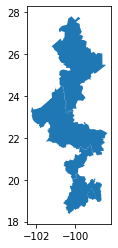

In [2]:
edos = marco.Entidades(nombres = ['ciudad de méxico','méxico','querétaro','san luis','nuevo león'])
edos.plot()

In [3]:
nl_municipios = marco.Municipios(entidades='19')
display(nl_municipios.head(10))

,geometry,cvegeo,cve_agee,cve_agem,nom_agem,cve_cab,pob,pob_fem,pob_mas,viv
0,"POLYGON ((-99.26413 25.91413, -99.26396 25.914...",19013,19,013,China,0001,9930,4969,4961,3268
1,"POLYGON ((-100.50415 24.45637, -100.49612 24.4...",19014,19,014,Doctor Arroyo,0001,36088,18028,18060,9229
2,"POLYGON ((-100.59196 25.25505, -100.58917 25.2...",19017,19,017,Galeana,0001,40903,20459,20444,11185
3,"POLYGON ((-99.92667 25.41633, -99.92575 25.415...",19038,19,038,Montemorelos,0001,67428,33859,33569,20912
4,"POLYGON ((-100.06809 25.99270, -100.06272 25.9...",19025,19,025,General Zuazua,0001,102149,50305,51844,29632
5,"POLYGON ((-100.39313 26.39482, -100.39268 26.3...",19045,19,045,Salinas Victoria,0001,86766,42631,44135,25430
6,"POLYGON ((-100.01204 26.16508, -100.00888 26.1...",19028,19,028,Higueras,0001,1386,662,724,422
7,"POLYGON ((-100.18769 26.32793, -100.18853 26.3...",19051,19,051,Villaldama,0001,3573,1786,1787,1267
8,"POLYGON ((-99.01603 26.09548, -99.00699 26.085...",19015,19,015,Doctor Coss,0001,1360,703,657,494
9,"POLYGON ((-99.80176 25.98994, -99.80161 25.989...",19016,19,016,Doctor González,0001,3256,1584,1672,1029


In [5]:
# definir las claves en su forma concatenada en vez de separadas por nivel de agregación permite realizar dioferentes combinaciones entre áreas:
# si se definen de manera separada una vez que se da una lista de áreas ya no se pueden definir los niveles siguiente. Es decir, si se pasa una lista de estados 
# no se puede definir un municipio, de manera que las posibilidades se reducen a una lista de estados, un estado con una lista de municipios, 
# un estado y un municipio con una lsita de localidades, y así sucesivamente. 

localidades = marco.LocalidadesAmanzanadas(entidades = '09', municipios = ['002','003','004','005'], as_geodf = False)
display(localidades)

,cvegeo,cve_agee,cve_agem,cve_loc,nom_loc,ambito,latitud,longitud,altitud,pob,viv,cve_carta,estatus,periodo
0,090020001,09,002,0001,Azcapotzalco,URBANO,19.4841028,-99.1843606,2244,432205,134204,E14A39,1,2015-06-01
1,090030001,09,003,0001,Coyoacán,URBANO,19.3502139,-99.1621456,2247,614447,191646,E14A39,1,2015-06-01
2,090040063,09,004,0063,Santa Rosa,RURAL,19.3233383,-99.2949614,2857,818,204,E14A39,1,2015-06-01
3,090040010,09,004,0010,Cruz Blanca,RURAL,19.3177850,-99.3240103,2982,728,192,E14A39,1,2015-06-01
4,090040050,09,004,0050,La Venta,RURAL,19.3343756,-99.3102128,2862,486,124,E14A39,1,2015-06-01
5,090040073,09,004,0073,Los Aguacates,RURAL,19.3699019,-99.3107319,2725,514,129,E14A39,1,2017-02-28
6,090040054,09,004,0054,Puerto las Cruces (Monte las Cruces),RURAL,19.2948611,-99.3476211,3200,1233,323,E14A38,1,2015-06-01
7,090040020,09,004,0020,San Lorenzo Acopilco,URBANO,19.3310047,-99.3256817,2936,26042,6627,E14A39,1,2015-06-01
8,090040001,09,004,0001,Cuajimalpa de Morelos,URBANO,19.3573503,-99.2997922,2780,186693,52530,E14A39,1,2015-06-01
9,090050001,09,005,0001,Gustavo A. Madero,URBANO,19.4829453,-99.1134708,2230,1173351,340301,E14A39,1,2015-06-01


In [6]:
# en cambio, las claves concatenadas permiten diferentes municipios de diferentes entidades o incluso hacer combinaciones entre los niveles de agregación 

localidades = marco.LocalidadesAmanzanadas(claves_concatenadas = ['01','09002','190310357'], as_geodf = False)
display(localidades.tail())

,cvegeo,cve_agee,cve_agem,cve_loc,nom_loc,ambito,latitud,longitud,altitud,pob,viv,cve_carta,estatus,periodo
392,010050106,01,005,0106,La Tomatina,RURAL,21.9014614,-102.4151539,1962,1076,249,F13D18,1,2015-06-01
393,010050007,01,005,0007,Los Arquitos,RURAL,21.9234458,-102.3857450,1908,1214,252,F13D18,1,2015-06-01
394,010050019,01,005,0019,Cieneguitas,RURAL,21.8954869,-102.4265219,1990,208,54,F13D18,1,2015-06-01
395,090020001,09,002,0001,Azcapotzalco,URBANO,19.4841028,-99.1843606,2244,432205,134204,E14A39,1,2015-06-01
396,190310357,19,031,0357,Anzures,URBANO,25.6905483,-100.1183050,0397,5222,1521,G14C26,1,2015-06-01


Clave Concatenada de Monterrey: 19039


<AxesSubplot:>

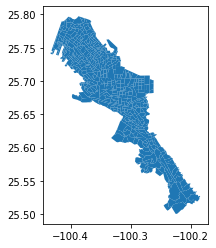

In [7]:
# podemos usar los valores de una tabla para apoyar en la búsqueda de otros valores cuando no se tenga la clave previamente
cve_concatenada = nl_municipios[nl_municipios.nom_agem == 'Monterrey'].cvegeo.iloc[0]
print('Clave Concatenada de Monterrey: {}'.format(cve_concatenada))
mty_agebs = marco.AGEBs(claves_concatenadas=cve_concatenada)
mty_agebs.plot()

<AxesSubplot:>

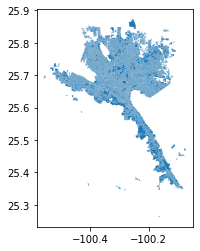

In [8]:
muns = ['021','039','046','048','049','019','026','006'] #claves de municipios correspondientes a la Zona Metropolitana de Monterrey
zmmty_manzanas = marco.Manzanas(entidades = '19', municipios = muns)
zmmty_manzanas.plot()

In [9]:
mty_vialidades = marco.Vialidades(entidades='19',municipios='039')
display(mty_vialidades.head())

,geometry,cve_agee,cve_agem,cve_loc,cve_via,nomvial,tipovial,ambito,sentido
0,"LINESTRING (-100.37921 25.77703, -100.37914 25...",19,039,0001,10523,Canal de Aztlán,Calle,Urbana,Dos sentidos
1,"LINESTRING (-100.24432 25.51150, -100.24430 25...",19,039,0001,04897,El Barro,Calle,Urbana,Dos sentidos
2,"LINESTRING (-100.39648 25.76720, -100.39619 25...",19,039,0001,10621,Almanzora,Calle,Urbana,Dos sentidos
3,"LINESTRING (-100.38965 25.77122, -100.38990 25...",19,039,0001,14309,Paseo de la Reserva,Calle,Urbana,Dos sentidos
4,"LINESTRING (-100.36222 25.77592, -100.36264 25...",19,039,0001,09818,15 de Abril,Privada,Urbana,Dos sentidos


### DENUE

``` python
class INEGIpy.DENUE(token)
```
**Parámetros** 
   * **token:** token proporcionado por el INEGI.

La clase ```DENUE``` contiene los métodos relacionados a la API del [Directorio Estadístico Nacional de Unidades Económicas](https://www.inegi.org.mx/servicios/api_denue.html), el cual permite consultar los datos de identificación, ubicación, actividad económica y tamaño de más de 5 millones de establecimientos a nivel nacional, por entidad federativa y municipio. Los métodos de esta clase permiten obtener un DataFrame o un GeodataFrame con la información de los establecimientos dadas ciertas condiciones como una ubicación y un radio, nombre del establecimiento, ubicación geográfica, actividad económica y estrato. Esta clase requiere un [token generado por el INEGI](https://www.inegi.org.mx/app/desarrolladores/generatoken/Usuarios/token_Verify).

Para cada establecimiento el INEGI proporciona la siguiente información: 
* CLEE
* Id de establecimiento
* Nombre del establecimiento
* Razón social
* Clase de la actividad económica
* Estrato (Personal ocupado)
* Tipo de la vialidad
* Calle
* Número exterior
* Número interior
* Colonia
* Código postal
* Localidad, municipio y entidad federativa
* Teléfono
* Correo electrónico
* Página de internet
* Tipo de establecimiento
* Longitud
* Latitud

#### Métodos

##### Buscar()

```python
DENUE.Buscar(condiciones, 
             latitud, 
             longitud, 
             distancia, 
             as_geodf = True)
```
**Parámetros**
* **condiciones:** str/list. Palabra(s) a buscar en el nombre del establecimiento, razón social, calle, colonia, clase de la actividad económica, entidad federativa, municipio y localidad. Para buscar todos los establecimientos se deberá ingresar la palabra "todos".
* **latitud:** float. Latitud que define el punto en el mapa a partir del cual se hará la consulta alrededor.
* **longitud:** float. Longitud que define el punto en el mapa a partir del cual se hará la consulta alrededor.
* **distancia:** int. Distancia en metros a partir de las coordenadas que definen el radio de búsqueda. La distancia máxima es de 5 000 metros.
* **as_geodf:** bool. Si el valor es verdadero regresa un GeoDataFrame para facilitar el análisis espacial. 

Recibe una o más condiciones, una coordenada y la distancia radial en metros con lo cual realiza una consulta de todos los establecimientos que cumplan las condiciones definidas dentro de la cirunferencia.

Regresa un DataFrame o GeoDataFrame con la información de los establecimientos consultados. 

##### Ficha()

```python
DENUE.Ficha(clave, 
            as_geodf = True)
```
**Parámetros**
* **clave:** str. ID única del establecimiento.
* **as_geodf:** bool. Si el valor es verdadero regresa un GeoDataFrame para facilitar el análisis espacial. 

Recibe la clave única de un establecimiento y obtiene su información.

Regresa un DataFrame o GeoDataFrame con la información de la consulta. 

##### Nombre()

```python
DENUE.Nombre(nombre, 
             entidad = '00', 
             registro_inicial = 1, 
             registro_final = 10, 
             as_geodf = True)
```
**Parámetros**
* **nombre:** str. Nombre del establecimiento ó razón social.
* **entidad:** str. Clave de dos dígitos de la entidad federativa (01 a 32). Para incluir todas las entidades se especifica 00.
* **registro_inicial:** int. Número de registro a partir del cuál se mostrarán los resultados de la búsqueda.
* **registro_final:** int. Número de registro final que se mostrará en los resultados de la búsqueda.
* **as_geodf:** bool. Si el valor es verdadero regresa un GeoDataFrame para facilitar el análisis espacial. 

Realiza una consulta de todos los establecimientos por nombre o razón social. La consulta puede ser acotada por entidad federativa. 

Regresa un DataFrame o GeoDataFrame con la información de la consulta. 

##### BuscarEntidad()

```python
DENUE.BuscarEntidad(condiciones, 
                    entidad = '00', 
                    registro_inicial = 1, 
                    registro_final = 10, 
                    as_geodf = True):
```
**Parámetros**
* **condiciones:** str/list. Palabra(s) a buscar en el nombre del establecimiento, razón social, calle, colonia, clase de la actividad económica, entidad federativa, municipio y localidad. Para buscar todos los establecimientos se deberá ingresar la palabra "todos".
* **entidad:** str. Clave de dos dígitos de la entidad federativa (01 a 32). Para incluir todas las entidades se especifica 00.
* **registro_inicial:** int. Número de registro a partir del cuál se mostrarán los resultados de la búsqueda.
* **registro_final:** int. Número de registro final que se mostrará en los resultados de la búsqueda.
* **as_geodf:** bool. Si el valor es verdadero regresa un GeoDataFrame para facilitar el análisis espacial. 

Realiza una consulta de todos los establecimientos que cumplan las condiciones definidas y puede ser acotada por entidad federativa.

Regresa un DataFrame o GeoDataFrame con la información de la consulta. 

##### BuscarAreaAct()

```python
DENUE.BuscarAreaActEstr(nombre,
                        clave_area = '', 
                        clave_actividad = '',
                        registro_inicial = 1, 
                        registro_final = 10, 
                        clave_establecimiento = '0', 
                        estrato = '0'
                        as_geodf = True)
```
**Parámetros**
* **nombre:** str. Nombre del establecimiento a buscar.
* **clave_area**: str. Clave de dos a dieciseis caracteres que indentifica el área geográfica de acuerdo con el Marco Geoestadístico. En caso de no definir una clave se regresan todos los establecimientos del país.
                                    Dos caracteres para definir un estado (ej. 01 a 32).
                                    Cinco caracteres dígitos para definir un municipio (ej. 01001).
                                    Nueve caracteres para definir una localidad (ej. 010010001).
                                    Trece caracteres para definir una Área Geoestadística Básica (AGEB) (ej. 010010001216A).
                                    Dieciseis caracteres para definir una manzana (ej. 010010001465A004).
* **clave_actividad**: str. Clave de dos a seis dígitos que identifica el área de actividad económica del establecimiento de acuerdo con el [Sistema de Clasificación Industrial de América del Norte 2018](https://www.inegi.org.mx/app/scian/). En caso de no definir una clave se regresan todas las áreas.
                                    Dos dígitos para definir un sector (ej.46).
                                    Tres dígitos para definir un subsector (ej. 464).
                                    Cuatro dígitos para definir una rama (ej. 4641).
                                    Cinco dígitos para definir una subrama (ej. 46411).
                                    Seis dígitos para definir una clase (ej. 464111).
* **registro_inicial:** int. Número de registro a partir del cuál se mostrarán los resultados de la búsqueda.
* **registro_final:** int. Número de registro final que se mostrará en los resultados de la búsqueda.
* **clave_establecimiento:** str. Clave única del establecimiento. Para incluir todos los establecimientos se especifica 0.
* **estrato**: str. Clave de un dígito que identifica el estrato del establecimiento (cantidad de trabajadores). Para incluir todos los tamaños se especifica 0.
                                    1. Para incluir de 0 a 5 personas.
                                    2. Para incluir de 6 a 10 personas.
                                    3. Para incluir de 11 a 30 personas.
                                    4. Para incluir de 31 a 50 personas.
                                    5. Para incluir de 51 a 100 personas.
                                    6. Para incluir de 101 a 250 personas.
                                    7. Para incluir de 251 y más personas.
* **as_geodf:** bool. Si el valor es verdadero regresa un GeoDataFrame para facilitar el análisis espacial. 

Realiza una consulta de todos los establecimientos con la opción de acotar la búsqueda por área geográfica, actividad económica, nombre, clave del establecimiento y estrato económico.

El INEGI divide esta función en dos: BuscarAreaAct y BuscarAreaActEstr. La diferencia entre ambas es que la segunda permite definir el estrato económico de los establecimientos y la primera no. Sin embargo, la segunda función permite la opción de buscar para todos los estratos cuando esta variable es igual a '0' lo cual hace que los resultados de ambas funciones sean iguales. Es por ello que en esta clase solo se definió un método para la segunda función ya que esta es más general y puede regresar los mismos resultados que la primera. A pesar de esto se conserva el nombre de la primera función por facilidad. 

Regresa un DataFrame o GeoDataFrame con la información de la consulta. 

##### Cuantificar()

```python
DENUE.Cuantificar(clave_area = '0', 
                  clave_actividad = '0', 
                  estrato = '0')
```
**Parámetros**
* **clave_area**: str/list. Clave(s) de dos a nueve caracteres que indentifican el área geográfica de acuerdo con el Marco Geoestadístico. Esta función solo permite definir hasta nivel localidad. En caso de no definir una clave se regresan todos los establecimientos del país.
                                    Dos caracteres para definir un estado (ej. 01 a 32).
                                    Cinco caracteres dígitos para definir un municipio (ej. 01001).
                                    Nueve caracteres para definir una localidad (ej. 010010001).
* **clave_actividad**: str/list. Clave(s) de dos a seis dígitos que identifican el área de actividad económica de los establecimientos de acuerdo con el [Sistema de Clasificación Industrial de América del Norte 2018](https://www.inegi.org.mx/app/scian/). Para incluir todas las actividades se especifica 0.
                                    Dos dígitos para definir un sector (ej.46).
                                    Tres dígitos para definir un subsector (ej. 464).
                                    Cuatro dígitos para definir una rama (ej. 4641).
                                    Cinco dígitos para definir una subrama (ej. 46411).
                                    Seis dígitos para definir una clase (ej. 464111).
* **estrato**: str. Clave de un dígito que identifica el estrato del establecimiento (cantidad de trabajadores). Para incluir todos los tamaños se especifica 0.
                                    1. Para incluir de 0 a 5 personas.
                                    2. Para incluir de 6 a 10 personas.
                                    3. Para incluir de 11 a 30 personas.
                                    4. Para incluir de 31 a 50 personas.
                                    5. Para incluir de 51 a 100 personas.
                                    6. Para incluir de 101 a 250 personas.
                                    7. Para incluir de 251 y más personas.

Realiza un conteo de todos los establecimientos con la opción de acotar la búsqueda por área geográfica, actividad económica y estrato.
        
A diferencia de las otras funciones permite múltiples claves para definir áreas geográficas y actividades económicas. 
        
Otra diferencia importante es que el resultado de esta consulta no regresa valores de las coordenadas para obtener un GeoDataFrame.

Regresa un DataFrame con las siguientes columnas:
* **AE:** Clave de la actividad económica.
* **AG:** Clave del Área Geoestadística.
* **Total:** Número de establecimientos que cumplen las condiciones definidas. 

#### Uso

In [12]:
from INEGIpy import DENUE
token = "TuToken"
denue = DENUE(token)

<AxesSubplot:>

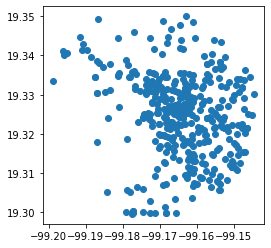

In [13]:
df = denue.Buscar('papeleria', latitud = 19.32593, longitud = -99.17253, distancia = 3_000)
df.plot()

In [14]:
df = denue.Ficha(clave = '993591', as_geodf=False)
display(df)

,CLEE,Id,Nombre,Razon_social,Clase_actividad,Estrato,Tipo_vialidad,Calle,Num_Exterior,Num_Interior,...,Ubicacion,Telefono,Correo_e,Sitio_internet,Tipo,Longitud,Latitud,CentroComercial,TipoCentroComercial,NumLocal
0,09003465311009331000000000U4,993591,PAPELERIA COPY PLUS,,Comercio al por menor de artículos de papelería,0 a 5 personas,CALLE,DALIAS,351,,...,"COYOACÁN, Coyoacán, CIUDAD DE MÉXICO",,COPYPLUS@LIVE.COM.MX,,Fijo,-99.17327717,19.32546362,,,


In [15]:
df = denue.Nombre(nombre = 'oxxo', registro_final= 5, as_geodf=False)
display(df)

,CLEE,Id,Nombre,Razon_social,Clase_actividad,Estrato,Tipo_vialidad,Calle,Num_Exterior,Num_Interior,...,Ubicacion,Telefono,Correo_e,Sitio_internet,Tipo,Longitud,Latitud,tipo_corredor_industrial,nom_corredor_industrial,numero_local
0,05027468411000082000008448S0,241407,OXXO GAS SUC. AEROPUERTO RAMOS SLW,SERVICIOS GASOLINEROS DE MEXICO SA DE CV,Comercio al por menor de gasolina y diesel,6 a 10 personas,BOULEVARD,MIGUEL RAMOS ARIZPE,157,,...,"RAMOS ARIZPE, Ramos Arizpe, COAHUILA DE ZARAGOZA",,ATENCIONCLIENTES@OXXOGAS.COM,WWW.OXXOGAS.COM,Fijo,-100.93934020,25.54427014,,,
1,05030468411001072000008448S7,241447,OXXO GAS SUC. ISIDRO LOPEZ,SERVICIOS GASOLINEROS DE MEXICO SA DE CV,Comercio al por menor de gasolina y diesel,6 a 10 personas,CALLE,Isidro López Zertuche,2600,0,...,"SALTILLO, Saltillo, COAHUILA DE ZARAGOZA",,ATENCIONCLIENTES@OXXOGAS.COM,WWW.OXXOGAS.COM,Fijo,-100.99782115,25.44916466,,,
2,05030468411000203000008448S6,242057,OXXO GAS SUC. ROTONDA,SERVICIOS GASOLINEROS DE MEXICO SA DE CV,Comercio al por menor de gasolina y diesel,11 a 30 personas,BOULEVARD,PRESIDENTE CARDENAS,1332,0,...,"SALTILLO, Saltillo, COAHUILA DE ZARAGOZA",,ATENCIONCLIENTES@OXXOGAS.COM,WWW.OXXOGAS.COM,Fijo,-100.98514108,25.42521447,,,
3,05030468411000932000008448S5,241448,OXXO GAS SUC. SAN RAMON MTD,SERVICIOS GASOLINEROS DE MEXICO SA DE CV,Comercio al por menor de gasolina y diesel,6 a 10 personas,PERIFERICO,Luis Echeverría,6133,0,...,"SALTILLO, Saltillo, COAHUILA DE ZARAGOZA",,ATENCIONCLIENTES@OXXOGAS.COM,WWW.OXXOGAS.COM,Fijo,-100.97589129,25.41574357,,,
4,05030468411000972001008448S6,241449,OXXO GAS SUC. VILLAFERRE SLW,SERVICIOS GASOLINEROS DE MEXICO SA DE CV,Comercio al por menor de gasolina y diesel,11 a 30 personas,BOULEVARD,VENUSTIANO CARRANZA,7625,,...,"SALTILLO, Saltillo, COAHUILA DE ZARAGOZA",,,,Fijo,-100.96658880,25.49452935,,,


In [16]:
df = denue.BuscarEntidad('papeleria', entidad='09', registro_final = 5, as_geodf=False)
display(df)

,CLEE,Id,Nombre,Razon_social,Clase_actividad,Estrato,Tipo_vialidad,Calle,Num_Exterior,Num_Interior,...,Ubicacion,Telefono,Correo_e,Sitio_internet,Tipo,Longitud,Latitud,tipo_corredor_industrial,nom_corredor_industrial,numero_local
0,09007433410000391001000000U7,744113,@PUNTO103,,Comercio al por menor de artículos de papelería,6 a 10 personas,CALLE,BATALLA DE LOMA ALTA,1261,0,...,"IZTAPALAPA, Iztapalapa, CIUDAD DE MÉXICO",,INTERNET_PUNTO103@HOTMAIL.COM,,Fijo,-99.07598675,19.38021053,,,
1,09012465311010991000000000U0,915779,1001 ARTICULOS,,Comercio al por menor de artículos de papelería,0 a 5 personas,PRIVADA,GUANAJUATO,71,,...,"TLALPAN, Tlalpan, CIUDAD DE MÉXICO",,,,Fijo,-99.18847911,19.28477654,,,
2,09015465311019173000003309S2,6760792,187 OFFICE MAX,OPERADORA OMX SA DE CV,Comercio al por menor de artículos de papelería,11 a 30 personas,CALLE,ISABEL LA CATÓLICA,39,,...,"CUAUHTÉMOC, Cuauhtémoc, CIUDAD DE MÉXICO",,,,Fijo,-99.13651997,19.43194609,,,
3,09002465311006551000000000U2,742977,309- 310- 316 PAPELERIA PROHOGAR,,Comercio al por menor de artículos de papelería,0 a 5 personas,CALLE,12,0,309,...,"AZCAPOTZALCO, Azcapotzalco, CIUDAD DE MÉXICO",,,,Fijo,-99.15394547,19.47588543,MERCADO PUBLICO,MERCADO PUBLICO SEDECO PRO HOGAR,"309, 310 Y 316"
4,09002465311009171000000000U6,9201165,407 PAPELERIA,,Comercio al por menor de artículos de papelería,0 a 5 personas,CALLE,12,,,...,"AZCAPOTZALCO, Azcapotzalco, CIUDAD DE MÉXICO",,,,Fijo,-99.15394547,19.47588543,MERCADO PUBLICO,MERCADO PUBLICO SEDECO PRO HOGAR,407


In [17]:
df = denue.BuscarAreaAct('soriana', clave_area = '09003', clave_actividad = '46', as_geodf = False)
display(df)

,CLEE,Id,Nombre,Razon_social,Clase_actividad,Estrato,Tipo_vialidad,Calle,Num_Exterior,Num_Interior,...,CLASE_ACTIVIDAD_ID,EDIFICIO_PISO,SECTOR_ACTIVIDAD_ID,SUBSECTOR_ACTIVIDAD_ID,RAMA_ACTIVIDAD_ID,SUBRAMA_ACTIVIDAD_ID,EDIFICIO,Tipo_Asentamiento,Fecha_Alta,AreaGeo
0,09003461110029761000000000U8,7717912,ABARROTES SORIANA,,"Comercio al por menor en tiendas de abarrotes,...",0 a 5 personas,CALLE,PASCLE,252,,...,461110,,46,461,4611,46111,,COLONIA,2019-11,090030001
1,09003462111000116000008292S5,6313488,CENTROS COMERCIALES SORIANA SUCURSAL 300 MIRAM...,TIENDAS SORIANA SA DE CV,Comercio al por menor en supermercados,101 a 250 personas,PEATONAL,1 Oriente (Avenida Canal de Miramontes),2600,0,...,462111,,46,462,4621,46211,,COLONIA,2010-07,090030001
2,09003461122004151001000000U6,908875,POLLERIA SORIANO,,Comercio al por menor de carne de aves,11 a 30 personas,CALLE,MARIQUITA SANCHEZ,,,...,461122,,46,461,4611,46112,,COLONIA,2014-12,090030001
3,09003462111000206000008292S4,6313076,SORIANA PLAZA CANTIL,TIENDAS SORIANA SA DE CV,Comercio al por menor en supermercados,101 a 250 personas,AVENIDA,Aztecas,270,0,...,462111,,46,462,4621,46211,,COLONIA,2010-07,090030001
4,09003462111000166000008292S0,6315772,TIENDAS SORIANA SUC 288 GRAN SUR,TIENDAS SORIANA SA DE CV,Comercio al por menor en supermercados,101 a 250 personas,AVENIDA,AVENIDA DEL IMÁN,151,0,...,462111,,46,462,4621,46211,,COLONIA,2010-07,090030001


In [18]:
df = denue.Cuantificar(clave_area = '09003', clave_actividad = ['464111', '464112'], estrato= '1') #farmacias con y sin minisuper en Coyoacán
display(df)

,AE,AG,Total
0,464111,09003,293
1,464112,09003,46


### Ruteo

``` python
class INEGIpy.Ruteo(token)
```
**Parámetros** 
   * **token:** token proporcionado por el INEGI.
   
La clase ```Ruteo``` contiene los métodos relacionados a la API del [Sistema de Ruteo de México](https://www.inegi.org.mx/servicios/Ruteo/Default.html). Esta API utiliza la Red Nacional de Caminos y todas sus especificaciones técnicas, para generar el resultado de acuerdo a las restricciones de circulación en el mundo real como sentidos de circulación vehicular, pasos a desnivel, distribuidores viales, enlaces, retornos glorietas, y maniobras prohibidas. Además, considera tres posibles rutas: preferentemente libre, preferentemente cuota y la ruta sugerida para dar alternativas de traslado o viaje con diferente coste. Además permite obtener información georeferenciada de los destinos que incluye la Red Nacional de Caminos como localidades urbanas y rurales o sitios de interés como aeropuertos, puertos, servicios médicos, centros educativos de nivel superior, playas, cascadas, zonas arqueológicas, museos, pueblos mágicos, y muchos más. 

Para el cálculo de rutas el INEGI define dos formas de marcar el inicio y final: 
* **Destino:** Sitio de partida o llegada para una ruta. Están integrados por localidades, instalaciones de transporte como aeropuertos y puertos, así como sitios de interés contenidos en la Red Nacional de Caminos.
* **Línea:** Es cualquier segmento de la Red Nacional de Caminos.

Los destinos y líneas se obtienen de sus respectivas funciones ```BuscarDestino``` y ```BuscarLinea```, los DataFrames resultantes de estas funciones contienen los valores necesarios para las funciones de ruteo. Las funciones de ruteo reciben estos DataFrames o diccionarios equivalentes para calcular las rutas.

#### Métodos

##### BuscarDestino()

```python
Ruteo.BuscarDestino(busqueda, 
                    cantidad, 
                    proyeccion = 'GRS80')
```
**Parámetros**
* **busqueda:** str. Define el nombre o parte del destino que se desea encontrar. Se puede utilizar una coma para especificar la entidad federativa, p. e. “San Juan, Jalisco”.
* **cantidad:** int. Número de destinos que se desea obtener. 
* **proyeccion:** str. Define la proyección de los puntos resultantes. GRS80 para coordenadas geográficas y MERC para coordenadas Spherical Mercator. Por default será GRS80. 
        
Permite buscar destinos como localidades urbanas y rurales, así como los sitios de interés que pueden ser instalaciones de servicios como aeropuertos, puertos, servicios médicos, centros educativos de nivel superior, así como sitios atractivos para el turismo como playas, cascadas, zonas arqueológicas, museos, pueblos mágicos, y más. El DataFrame resultante contiene los valores necesarios para calcular una ruta desde o hacia el destino.

Obtiene un GeoDataFrame con la información de las siguientes columnas:

* **id_dest:** identificador único del destino.*
* **ent_abr:** abreviación de la entidad federativa en donde se encuentra el destino.
* **nombre:** nombre del destino.
* **geometry:** geometría del punto geográfico del destino.

**Valor necesario para calcular una ruta desde o hacia el destino definido*

##### BuscarLinea()

```python
Ruteo.BuscarLinea(lat, 
                  lng, 
                  escala = 1_000_000, 
                  proyeccion = 'GRS80')
```
**Parámetros**
* **lat:** float. Latitud de la coordenada.
* **lng:** float. Longitud de la coordenada.
* **escala:** int. Valor de la escala de visualización. Por default es 1,000,000.
* **proyeccion:** str. Define la proyección de los puntos resultantes. GRS80 para coordenadas geográficas y MERC para coordenadas Spherical Mercator. Por default será GRS80. 
        
Obtiene un GeoDataFrame con la información de la línea registrada en la Red Nacional de Caminos más cercana a una coordenada. El DataFrame resultante contiene los valores necesarios para calcular una ruta desde o hacia la coordenada:

* **id_routing_net:** identificador de la línea.*
* **source:** source de la línea.*
* **target:** target de la línea.*
* **nombre:** nombre de la línea (carretera, camino o avenida).
* **geometry:** geometría de un punto de la línea más cercano a las coordenadas enviadas.

**Valores necesarios para calcular una ruta desde o hacia la coordenada definida*

##### CalcularRuta()

```python
Ruteo.CalcularRuta(linea_inicial = None, 
                   linea_final = None, 
                   destino_inicial = None, 
                   destino_final = None, 
                   tipo_vehiculo = 0, 
                   ruta = 'optima', 
                   ejes_excedentes = 0, 
                   saltar_lineas = None, 
                   proyeccion = 'GRS80')
```
**Parámetros**
* **linea_inicial:** DataFrame con las columnas id_routing_net, source y target de la línea inicial obtenido por la función BuscarLinea. También acepta un diccionario con la misma información.
* **linea_final:** DataFrame con las columnas id_routing_net, source y target de la línea final obtenido por la función BuscarLinea. También acepta un diccionario con la misma información.
* **destino_inicial:** DataFrame con la columna id_dest del destino inicial obtenido por la función BuscarDestino. También acepta el valor de id_dest en string o integer. 
* **destino_final:** DataFrame con la columna id_dest del destino final obtenido por la función BuscarDestino. También acepta el valor de id_dest en string o integer. 
* **tipo_vehiculo:** int. Clave de un dígito que identifica el tipo de vehículo con el cual calcular la ruta. Por default es 0. 
                                0: Motocicleta
                                1: Automóvil
                                2: Autobús dos ejes
                                3: Autobús tres ejes
                                4: Autobús cuatro ejes
                                5: Camión dos ejes
                                6: Camión tres ejes
                                7: Camión cuatro ejes
                                8: Camión cinco ejes
                                9: Camión seis ejes
                                10: Camión siete ejes
                                11: Camión ocho ejes
                                12: Camión nueve ejes
* **ruta:** str. ["optima" | "libre" | "cuota"]. Tipo de ruta que se desea obtener. 
* **ejes_excedentes:** int. Clave de un dígito que identifica el número de ejes excedentes del vehículo. Por default es 0.
                                0: Sin ejes excedentes
                                1: un eje excedente
                                2: dos ejes excedentes
                                3: tres ejes excedentes
                                4: cuatro ejes excedentes
                                5: cinco ejes excedentes
* **saltar_lineas:** list. Lista con los id_routing_net de las líneas por las cuales la ruta no pasará por ningún motivo. Por default es None.
* **proyeccion:** str. Define la proyección de los puntos resultantes. GRS80 para coordenadas geográficas y MERC para coordenadas Spherical Mercator. Por default será GRS80. 
        
Obtiene un GeoDataFrame con la ruta calculada por Sistema de Ruteo de México y la Red Nacional de Caminos. Se puede obtener rutas de línea-línea, destino-destino, línea-destino y destino-linea. El DataFrame resultante contine las columnas:

* **long_km:** longitud en kilómetros de la ruta.
* **tiempo_min:** tiempo promedio en minutos de traslado de la ruta.
* **peaje:** False si la ruta no pasa por alguna caseta de cobro y True si pasa por al menos una.
* **costo_caseta:** cantidad en pesos que pagará al transitar por esta ruta.
* **eje_excedente:** cantidad en pesos que pagaría al transitar por esta ruta en caso que el parámetro e sea mayor o igual a 1. Si e es igual a cero, no se devolverá este resultado.
* **advertencia:** devuelve una advertencia cuando la ruta tiene algunas características específicas que el usuario debiera conocer.
* **geometry:** geometría de la línea con la ruta.


##### DetalleRuta()

```python
Ruteo.DetalleRuta(linea_inicial = None, 
                  linea_final = None, 
                  destino_inicial = None, 
                  destino_final = None, 
                  tipo_vehiculo = 0, 
                  ruta = 'optima', 
                  ejes_excedentes = 0, 
                  saltar_lineas = None, 
                  proyeccion = 'GRS80')
```
**Parámetros**
* **linea_inicial:** DataFrame con las columnas id_routing_net, source y target de la línea inicial obtenido por la función BuscarLinea. También acepta un diccionario con la misma información.
* **linea_final:** DataFrame con las columnas id_routing_net, source y target de la línea final obtenido por la función BuscarLinea. También acepta un diccionario con la misma información.
* **destino_inicial:** DataFrame con la columna id_dest del destino inicial obtenido por la función BuscarDestino. También acepta el valor de id_dest en string o integer. 
* **destino_final:** DataFrame con la columna id_dest del destino final obtenido por la función BuscarDestino. También acepta el valor de id_dest en string o integer. 
* **tipo_vehiculo:** int. Clave de un dígito que identifica el tipo de vehículo con el cual calcular la ruta. Por default es 0. 
                                0: Motocicleta
                                1: Automóvil
                                2: Autobús dos ejes
                                3: Autobús tres ejes
                                4: Autobús cuatro ejes
                                5: Camión dos ejes
                                6: Camión tres ejes
                                7: Camión cuatro ejes
                                8: Camión cinco ejes
                                9: Camión seis ejes
                                10: Camión siete ejes
                                11: Camión ocho ejes
                                12: Camión nueve ejes
* **ruta:** str. ["optima"|"libre"|"cuota"]. Tipo de ruta que se desea obtener. 
* **ejes_excedentes:** int. Clave de un dígito que identifica el número de ejes excedentes del vehículo. Por default es 0.
                                0: Sin ejes excedentes
                                1: un eje excedente
                                2: dos ejes excedentes
                                3: tres ejes excedentes
                                4: cuatro ejes excedentes
                                5: cinco ejes excedentes
* **saltar_lineas:** list. Lista con los id_routing_net de las líneas por las cuales la ruta no pasará por ningún motivo. Por default es None.
* **proyeccion:** str. Define la proyección de los puntos resultantes. GRS80 para coordenadas geográficas y MERC para coordenadas Spherical Mercator. Por default será GRS80. 

Obtiene un GeoDataFrame con los detalles de la ruta calculada por Sistema de Ruteo de México y la Red Nacional de Caminos. Se puede obtener rutas de línea-línea, destino-destino, línea-destino y destino-linea. El DataFrame resultante contine las columnas:

* **direccion:** Dirección de giro y nombre de la carretera, camino o vialidad.
* **long_m:** Longitud del segmento en metros.
* **tiempo_min:** Tiempo de recorrido del segmento en minutos.
* **costo_caseta:** Cantidad en pesos a pagar por transitar por el segmento.
* **punto_caseta:** Geometría de la caseta asociada al segmento (en caso de existir una asociación).
* **eje_excedente:** Cantidad en pesos a pagar por los ejes excedentes.
* **giro:** Valor numérico que indica hacia donde se debe girar.
                                0: Continúe derecho
                                1: Gire a la izquierda
                                2: Gire a la derecha
                                3: Gire ligeramente a la izquierda
                                4: Gire ligeramente a la derecha
* **geometry:** Geometría con los puntos que marcan a los segmentos.
                                
##### Combustibles()

```python
Ruteo.Combustibles()
```
Regresa un DataFrame con los 4 tipos de combustibles más comunes y su costo promedio que se consultan el primer día hábil de cada semana en la página web de la [Comisión Reguladora de Energía del Gobierno Federal](https://www.gob.mx/cre)

Nota: el dato que provee esta API solo es una referencia en función del precio promedio nacional excluyendo las 7 regiones sobre la frontera. También lo que refiere al gas LP el precio es un promedio ponderado que publica la Comisión Reguladora de Energía.

El DataFrame resultante contine las columnas:

* **tipo_costo:** Tipo y costo promedio del combustible.
* **costo:** Costo promedio del combustible.
* **tipo:** Nombre del combustible.

#### Uso

In [19]:
from INEGIpy import Ruteo
token = "TuToken"
ruteo = Ruteo(token)

In [20]:
destino_inicial = ruteo.BuscarDestino(busqueda = 'palacio de bellas artes, ciudad de m', cantidad = 1)
destino_final = ruteo.BuscarDestino(busqueda = 'zócalo, ciudad de m', cantidad = 1)
display(destino_inicial)
display(destino_final)

,ent_abr,id_dest,nombre,geometry
0,CDMX,6773,"Palacio de Bellas Artes, Cuauhtémoc",POINT (-99.14137 19.43524)


,ent_abr,id_dest,nombre,geometry
0,CDMX,4437,"Plaza de la Constitución, Cuauhtémoc",POINT (-99.13320 19.43263)


In [21]:
linea_inicial = ruteo.BuscarLinea(lat = 19.435237353, lng = -99.141374223) # equvalente a buscar bellas artes pero con las coordenadas
linea_final = ruteo.BuscarLinea(lat = 19.4326290000001, lng = -99.133203) # equivalente a buscar zócalo con las coordenadas
display(linea_inicial)
display(linea_final)

,source,id_routing_net,nombre,target,geometry
0,701895,695491,Eje vial Central Lázaro Cárdenas,701896,POINT (-99.14070 19.43514)


,source,id_routing_net,nombre,target,geometry
0,769724,1475230,Calle Plaza de la Constitución,769725,POINT (-99.13332 19.43328)


In [22]:
ruta_optima = ruteo.CalcularRuta(linea_inicial = linea_inicial, linea_final = linea_final, tipo_vehiculo = 1, ruta = 'optima')

# Las siguientes combinaciones serían equivalentes:
#ruteo.CalcularRuta(linea_inicial = linea_inicial, destino_final = destino_final, tipo_vehiculo = 1, ruta = 'optima')
#ruteo.CalcularRuta(destino_inicial = destino_inicial, linea_final = linea_final, tipo_vehiculo = 1, ruta = 'optima')
#ruteo.CalcularRuta(destino_inicial = destino_inicial, destino_final = destino_final, tipo_vehiculo = 1, ruta = 'optima')

display(ruta_optima)

,costo_caseta,tiempo_min,advertencia,long_km,peaje,geometry
0,0.0,3.79,,2.53,False,"MULTILINESTRING ((-99.13344 19.43195, -99.1326..."


In [23]:
detalle_ruta = ruteo.DetalleRuta(linea_inicial = linea_inicial, linea_final = linea_final, tipo_vehiculo = 1, ruta = 'optima')
display(detalle_ruta)

,eje_excedente,costo_caseta,tiempo_min,long_m,punto_caseta,direccion,giro,geometry
0,0.0,0.0,0.000000,0.000000,None,Inicia recorrido en Eje vial Central Lázaro Cá...,0,POINT (-99.14085 19.43421)
1,0.0,0.0,0.911682,607.788044,None,Continúe por Eje vial Central Lázaro Cárdenas ...,0,POINT (-99.14085 19.43421)
2,0.0,0.0,0.402828,268.551789,None,Gire a la derecha en Calle República de Perú,2,POINT (-99.14002 19.43966)
3,0.0,0.0,0.639794,426.529251,None,Gire a la derecha en Calle Ignacio Allende,2,POINT (-99.13746 19.43956)
4,0.0,0.0,0.215491,143.660612,None,Continúe por Calle Bolívar,0,POINT (-99.13802 19.43573)
5,0.0,0.0,0.662375,441.583560,None,Gire a la izquierda en Calle 5 de Mayo,1,POINT (-99.13822 19.43444)
6,0.0,0.0,0.136318,90.878944,None,Gire a la derecha en Calle Monte de Piedad,2,POINT (-99.13404 19.43397)
7,0.0,0.0,0.826011,550.674086,None,Continúe por Calle Plaza de la Constitución,1,POINT (-99.13411 19.43315)
8,0.0,0.0,0.000000,0.000000,None,¡Haz llegado a tu destino!,0,POINT (-99.13411 19.43315)


In [24]:
combustibles = ruteo.Combustibles()
display(combustibles)

,tipo,tipo_costo,costo
0,Magna,Magna $19.80/l,19.80
1,Premium,Premium $21.09/l,21.09
2,Diésel,Diésel $21.26/l,21.26
3,Gas,Gas $10.01/l,10.01


## Casos de uso

### Indicadores y MarcoGeoestadistico

In [2]:
from INEGIpy import Indicadores, MarcoGeoestadistico

In [3]:
token = 'TuToken'
inegi = Indicadores(token)
marco = MarcoGeoestadistico()

In [34]:
indicadores = [str(i) for i in range(472080,472112)] # indicadores del PIB real por entidad federativa
entidades = marco.Entidades()
nombres = entidades.nom_agee.tolist() # nombres de las entidades
pib_edos = inegi.obtener_df(indicadores = indicadores, nombres = nombres, inicio = '2019')
display(pib_edos)

,Aguascalientes,Baja California,Baja California Sur,Campeche,Coahuila de Zaragoza,Colima,Chiapas,Chihuahua,Ciudad de México,Durango,...,Quintana Roo,San Luis Potosí,Sinaloa,Sonora,Tabasco,Tamaulipas,Tlaxcala,Veracruz de Ignacio de la Llave,Yucatán,Zacatecas
fechas,,,,,,,,,,,,,,,,,,,,,
2019-01-01,222456.200,575342.251,158953.105,517311.384,603930.571,109109.572,261697.349,572966.871,3133078.905,204061.056,...,290611.760,368672.808,398162.683,580759.016,448890.121,517422.426,103566.865,801624.782,263372.187,151905.742
2020-01-01,204142.637,553945.092,121577.942,482973.093,535373.609,101068.064,251650.751,539293.544,2848733.731,190239.040,...,220550.379,340576.121,370202.628,549564.663,464512.613,473593.124,91004.963,737040.168,243120.969,145571.953


In [35]:
# sacamos la tasa de crecimiento
cambios_pcts = pib_edos.pct_change()
display(cambios_pcts)

,Aguascalientes,Baja California,Baja California Sur,Campeche,Coahuila de Zaragoza,Colima,Chiapas,Chihuahua,Ciudad de México,Durango,...,Quintana Roo,San Luis Potosí,Sinaloa,Sonora,Tabasco,Tamaulipas,Tlaxcala,Veracruz de Ignacio de la Llave,Yucatán,Zacatecas
fechas,,,,,,,,,,,,,,,,,,,,,
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,-0.082324,-0.03719,-0.235133,-0.066378,-0.113518,-0.073701,-0.03839,-0.05877,-0.090756,-0.067735,...,-0.241082,-0.07621,-0.070223,-0.053713,0.034802,-0.084707,-0.121293,-0.080567,-0.076892,-0.041696


In [36]:
cambios_pcts = cambios_pcts.stack().reset_index()
cambios_pcts.columns = ['fechas','nom_agee','cambio_pct_pib_real']
display(cambios_pcts.head())

,fechas,nom_agee,cambio_pct_pib_real
0,2020-01-01,Aguascalientes,-0.082324
1,2020-01-01,Baja California,-0.037190
2,2020-01-01,Baja California Sur,-0.235133
3,2020-01-01,Campeche,-0.066378
4,2020-01-01,Coahuila de Zaragoza,-0.113518


In [37]:
entidades = entidades.merge(cambios_pcts, how = 'left')
entidades.cambio_pct_pib_real = entidades.cambio_pct_pib_real*100
display(entidades.head())

,geometry,cvegeo,cve_agee,nom_agee,nom_abrev,pob,pob_fem,pob_mas,viv,fechas,cambio_pct_pib_real
0,"POLYGON ((-102.28787 22.41649, -102.28753 22.4...",01,01,Aguascalientes,Ags.,1425607,728924,696683,386671,2020-01-01,-8.232435
1,"MULTIPOLYGON (((-117.10047 32.53656, -117.0992...",02,02,Baja California,BC,3769020,1868431,1900589,1149563,2020-01-01,-3.719031
2,"MULTIPOLYGON (((-112.75825 27.97538, -112.7574...",03,03,Baja California Sur,BCS,798447,392568,405879,240660,2020-01-01,-23.513327
3,"MULTIPOLYGON (((-90.37936 20.84833, -90.38182 ...",04,04,Campeche,Camp.,928363,471424,456939,260824,2020-01-01,-6.637838
4,"POLYGON ((-102.31079 29.87695, -102.31050 29.8...",05,05,Coahuila de Zaragoza,Coah.,3146771,1583102,1563669,901249,2020-01-01,-11.351795


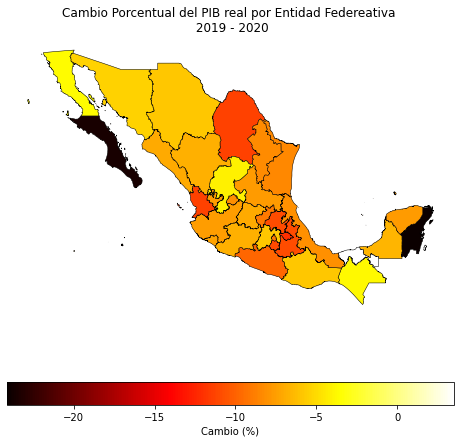

In [67]:
ax = entidades.plot(column = 'cambio_pct_pib_real', 
                    cmap = 'hot',
                    legend = True, 
                    legend_kwds={'label':'Cambio (%)', 'orientation':"horizontal"},
                    figsize = (8,8),
                    edgecolor = 'black',
                    linewidth = 0.5)
ax.set_title('Cambio Porcentual del PIB real por Entidad Federeativa \n 2019 - 2020')
ax.set_axis_off()

### DENUE, Ruteo y MarcoGeoestadistico

#### Negocios a 5km de una coordenada

##### Distancia radial

In [85]:
from INEGIpy import DENUE, MarcoGeoestadistico, Ruteo
import geopandas as gpd
import pandas as pd

In [69]:
token = 'TuToken'
denue = DENUE(token)
marco = MarcoGeoestadistico()
token_ruteo = 'TuOtroToken'
ruteo = Ruteo(token_ruteo)

In [70]:
# construimos una capa para la zona a buscar
zocalo = ruteo.BuscarDestino(busqueda = 'zócalo, ciudad de m', cantidad = 1)
display(zocalo)

,ent_abr,id_dest,nombre,geometry
0,CDMX,4437,"Plaza de la Constitución, Cuauhtémoc",POINT (-99.13320 19.43263)


<AxesSubplot:>

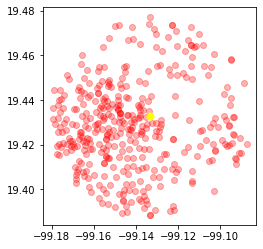

In [71]:
# utilizamos el DENUE para obtener una capa con los establecimientos en un radio de 5 km 
# inicié queriendo ver todos los establecimientos pero son demasiados para hacer buenos visuales así que acoté a solo los Oxxos
lat, lng = zocalo.geometry.iloc[0].y, zocalo.geometry.iloc[0].x
estabs = denue.Buscar('oxxo',lat,lng,5000)

ax = zocalo.plot(color='yellow', zorder=2, markersize=50)
estabs.plot(ax=ax, alpha=0.3, color='red', zorder=1)

<AxesSubplot:>

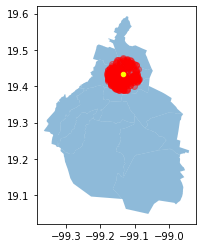

In [72]:
# utilizamos el marco geostadistico para obtener la capa del area geografica sobre la que plotear
# Si no conoces la clave de alguna entidad, municipio o localidad la puedes buscar por nombre en el marco geoestadístico

# regresa todas las manzanas en CDMX
muns = marco.Municipios(entidades='09')

ax = muns.plot(alpha = 0.5)
zocalo.plot(ax=ax, color='yellow', zorder=2, markersize=20)
estabs.plot(ax=ax, color='red', alpha=0.4)

<AxesSubplot:>

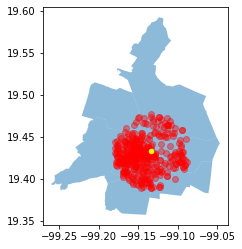

In [75]:
# reducimos a solo los municipios en el area con un join espacial

muns = gpd.sjoin(muns, estabs).dissolve('cve_agem') 

ax = muns.plot(alpha = 0.5)
zocalo.plot(ax=ax, color='yellow', zorder=2, markersize=20)
estabs.plot(ax=ax, color='red', alpha=0.4)

In [76]:
# ya podemos hacer operaciones y obtener datos como las distancias al punto definido:
# para poder tener las distancias en metros necesitamos cambiar los crs de los geodataframes
zocalo = zocalo.to_crs('EPSG:6372')
estabs = estabs.to_crs('EPSG:6372')
muns = muns.to_crs('EPSG:6372')

estabs['distancia_radial'] = estabs.geometry.distance(zocalo.geometry.iloc[0])

In [77]:
# podemos ver que la distancia mínima son 300 metros, la máxima es cercana a los 5 km y la media es de 3.1 km

estabs.distancia_radial.min(), estabs.distancia_radial.max(), estabs.distancia_radial.mean()

(217.4387129171983, 4983.678746895861, 3130.050858409257)

<AxesSubplot:>

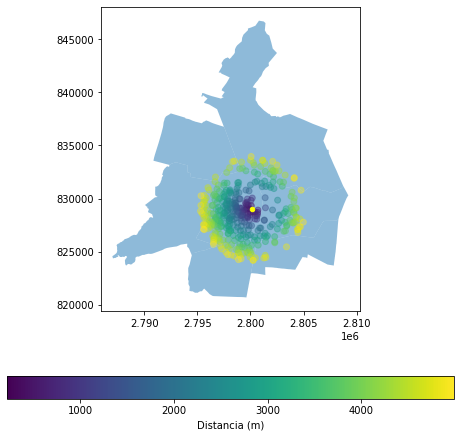

In [78]:
ax = muns.plot(alpha = 0.5, figsize=(8,8))
zocalo.plot(ax=ax, color='yellow', zorder=2, markersize=20)
estabs.plot(ax=ax, alpha=0.4, column='distancia_radial', legend = True, legend_kwds={'label':'Distancia (m)','orientation':"horizontal"})

<AxesSubplot:>

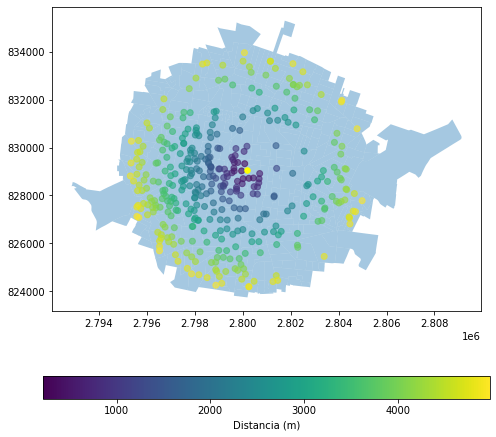

In [79]:
# podemos mejorar el mapa si usamos un nivel de agregación menor

agebs = marco.AGEBs(entidades = '09', municipios = muns.index.tolist())
agebs = agebs.to_crs('EPSG:6372')
agebs = agebs[agebs.geometry.intersects(zocalo.geometry.iloc[0].buffer(5000))]

ax = agebs.plot(alpha = 0.4, figsize=(8,8), zorder=1)
zocalo.plot(ax=ax, color='yellow', zorder=3, markersize=30)
estabs.plot(ax=ax, alpha=0.6, column='distancia_radial',
            legend = True, legend_kwds={'label':'Distancia (m)','orientation':"horizontal"}, zorder=2)

<AxesSubplot:>

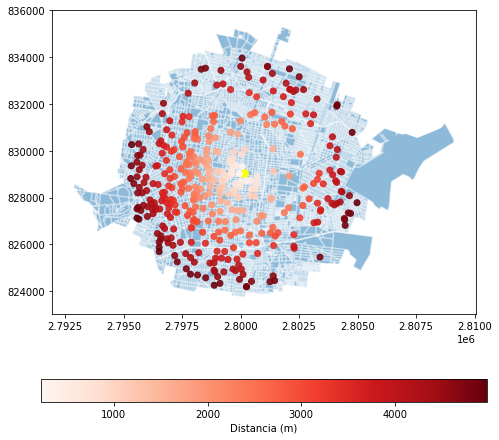

In [80]:
# para mejorar el mapa también podemos plotear las vialidades

vialidades = marco.Vialidades(entidades='09', municipios=muns.index.tolist())
vialidades = vialidades.to_crs('EPSG:6372')
agebs_dis = agebs.dissolve(by='cve_ent')
vialidades = vialidades[vialidades.geometry.intersects(agebs_dis.geometry.iloc[0])]

ax = agebs_dis.plot(alpha = 0.5, figsize=(8,8), zorder=1)
vialidades.plot(ax=ax, color='white', alpha=0.5, zorder=2)
zocalo.plot(ax=ax, color='yellow', zorder=3, markersize=60)
estabs.plot(ax=ax, alpha=0.9, column='distancia_radial', cmap='Reds',
            legend = True, legend_kwds={'label':'Distancia (m)','orientation':"horizontal"},zorder=4)

##### Distancia en ruta

In [81]:
# primero obtenemos la calle más cerca del punto inicial definido
# Para estopodemos usar la función BuscarLinea del módulo de ruteo

linea_i =  ruteo.BuscarLinea(lat, lng)
display(linea_i)

,source,id_routing_net,nombre,target,geometry
0,769724,1475230,Calle Plaza de la Constitución,769725,POINT (-99.13332 19.43328)


In [82]:
# Para calcular una ruta se requiere la utilizar la función BuscarLinea (o BuscarDestino dependiendo de lo que se busca) con el fin de obtener la línea final de la ruta
# Como tenemos varios puntos finales más bien sería una lista de líneas

# Noté que en ocasiones el Sistema de Ruteo no encuentra información para una coordenada si la escala no está correcta por lo que aumenté el valor default de 
# la escala a 1,000,000 lo cual resolvió el problema para las coordenadas resultantes del DENUE sin embargo es importante tenerlo en cuenta para otras bases. 

lineas_f = [ruteo.BuscarLinea(estabs.Latitud.iloc[i], estabs.Longitud.iloc[i]) for i in range(estabs.shape[0])]
len(lineas_f)

385

In [83]:
# una vez con las líneas resultantes de cada oxxo usamos la función CalcularRuta para obtener la rúta óptima desdse el punto inicial en el zócalo
# solo debemos darle como argumentos los DataFrames resultantes

# El INEGI no me ha respondido sobre límites o preferencias de uso pero noté que las primeras 280 rutas las calcula más rápido y a partir de ahí se alenta
# en lo que me responen estoy pausando cada 100 requests por si es una cuestión de límites aunque también puede ser que esas rutas tomen más tiempo por ser más largas
# el tiempo en el que corre la celda se acortó con el time.sleep(30) así que sí puede ser una cuesstión de límites
import time

rutas = []
for j in range(len(lineas_f)):
    r = ruteo.CalcularRuta(linea_i, lineas_f[j])
    rutas.append(r)
    if j%100 == 0: time.sleep(30)
    
len(rutas)

385

In [86]:
rutas = gpd.GeoDataFrame(pd.concat(rutas,axis=0).reset_index(drop=True))
display(rutas.head())

,costo_caseta,tiempo_min,advertencia,long_km,peaje,geometry
0,0.0,0.50,,0.34,False,"MULTILINESTRING ((-99.13322 19.43332, -99.1333..."
1,0.0,1.31,,0.90,False,"MULTILINESTRING ((-99.13344 19.43195, -99.1326..."
2,0.0,1.26,,1.06,False,"MULTILINESTRING ((-99.13236 19.43078, -99.1330..."
3,0.0,0.50,,0.34,False,"MULTILINESTRING ((-99.13322 19.43332, -99.1333..."
4,0.0,1.90,,1.31,False,"MULTILINESTRING ((-99.13236 19.43078, -99.1314..."


In [87]:
# con las rutas ya podemos tener la distancia y clasificar así los puntos
# la columna long_km y el length que calcula Shapely difiere por metros, ambos son de fácil acceso así que cualquiera se puede usar

estabs['distancia_ruta'] = rutas.long_km

<AxesSubplot:>

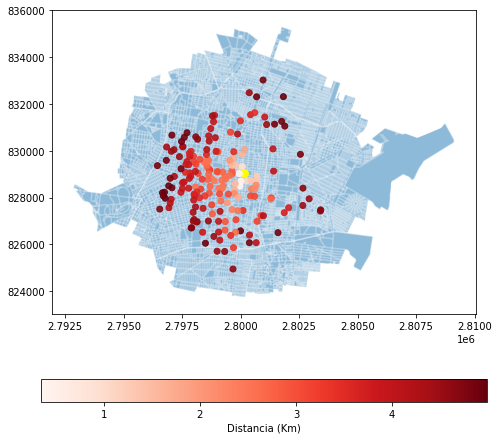

In [88]:
# Finalmente podemos visualizar los oxxos que se encuentran a 5 km en ruta 

ax = agebs_dis.plot(alpha = 0.5, figsize=(8,8), zorder=1)
vialidades.plot(ax=ax, color='white', alpha=0.3, zorder=2)
zocalo.plot(ax=ax, color='yellow', zorder=3, markersize=60)
estabs[estabs.distancia_ruta <= 5].plot(ax=ax, alpha=0.9, column='distancia_ruta', cmap='Reds',
            legend = True, legend_kwds={'label':'Distancia (Km)','orientation':"horizontal"},zorder=4)